In [67]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [68]:
%matplotlib inline

from scipy.io import wavfile
from scipy import signal, fftpack, ndimage
from scipy.ndimage import gaussian_filter, median_filter
from scipy.signal import medfilt, savgol_filter

from sklearn.decomposition import FastICA, NMF
from skimage.filters import *
from skimage.morphology import disk

import numpy as np
import math

import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Image

import librosa
import librosa.display

import imageio
import cv2

import heapq
import random
from operator import xor

In [244]:
# dataset = '/content/drive/My Drive/AudioDataSet/test.wav'
# dataset = '/content/drive/My Drive/AudioDataSet/higherground.wav'
# dataset = '/content/drive/My Drive/AudioDataSet/higherground_piano.wav'

dataset = '/content/drive/My Drive/AudioDataSet/samp1.wav'

In [245]:
fs, waveform = wavfile.read(dataset)
if len(waveform.shape) > 1:
    waveform = np.sum(waveform, axis=1).astype(float)

In [246]:
# load audio clip

duration = 5.0 # duration

# 40, 30, 70, 10032
# random.seed(30)

n_samples = int(duration * fs)
start = random.randint(0, len(waveform) - n_samples)
y = waveform[start:start + n_samples].astype(float)

ipd.display(ipd.Audio(y, rate=fs))

In [247]:
# resample audio clip

ds = 2
sr = int(np.round(fs / ds))

audio_clip = signal.decimate(y, ds)

ipd.display(ipd.Audio(audio_clip, rate=sr))

In [248]:
def minimize_energy(points, alpha=0.2, beta=0.5, iters=20, constraints=set()):
    if len(points) < 3: return points

    minimized_points = points.copy()
    
    for _ in range(iters):
        for i in range(0, len(minimized_points)):
            if i in constraints: 
                continue
            p1d, p2d = 0 if i < 1 else i - 1, 0 if i < 2 else i - 2
            seg1d, seg2d = minimized_points[p1d:p1d+2], \
                            minimized_points[p2d:p2d+3]
            stretch = np.gradient(seg1d)
            bend = np.gradient(np.gradient(seg2d))
            minimized_points[i] -= (alpha * stretch[len(stretch)//2]) + (beta * bend[len(bend)//2])

    minimized_points[minimized_points < 0.0] = 0.0
    return minimized_points

def normalize(img, range=255):
    output = (img - np.min(img)).astype(float)
    output /= np.max(output)
    output = (output * range).astype(np.uint8)
    return output

def remove_small_components(image, filter_size=10):
    filtered = image.copy()
    for i in range(len(filtered)):
        row = np.concatenate((filtered[i], [0]))
        prev_pixel, comp_size = row[0], int(row[0] != 0.0)
        for j in range(1, len(row)):
            if row[j] == 0.0:
                if comp_size <= filter_size:
                    row[j - comp_size:j] = np.zeros((comp_size,))
                comp_size = 0
            else:
                comp_size += 1
        filtered[i,:] = row[:-1]
    return filtered

def diff_matrix(matrix):
    onsets = np.zeros((matrix.shape[0], matrix.shape[1]))
    for i, bar in enumerate(matrix):
        bar = np.concatenate(([0], bar))
        spectral = np.ediff1d(bar)
        onsets[i,:] = spectral 
    return onsets

center = lambda x: (x - np.average(x)) / np.std(x)

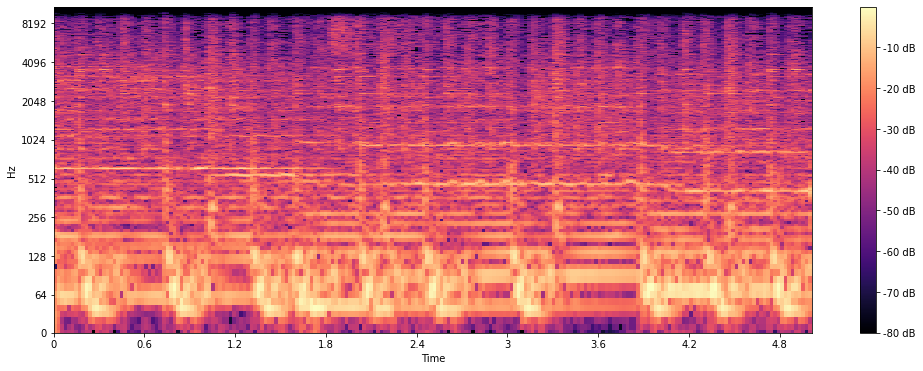

In [249]:
n_fft = 2048
hop_length = 512
n_mels = 256

S = librosa.core.stft(audio_clip, n_fft=n_fft, hop_length=hop_length, window='hann')
S_DB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

plt.figure(figsize=(17, 6))
librosa.display.specshow(S_DB, sr=sr, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')

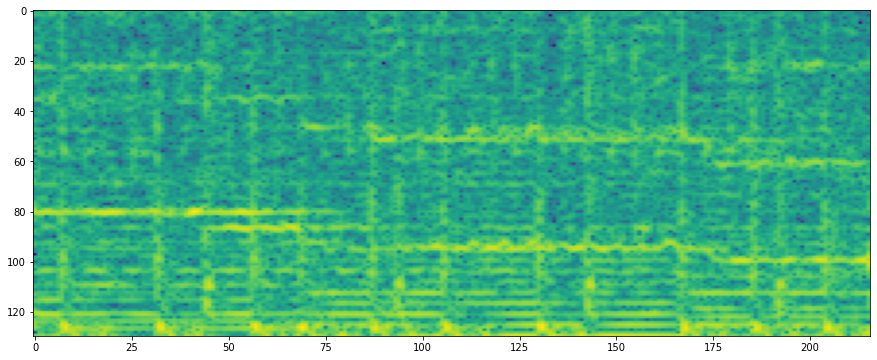

In [250]:
start = np.argmin(np.abs(100 - frequencies))
end = np.argmin(np.abs(1500 - frequencies))
spectrogram = S_DB[start:end].copy()
frequencies = frequencies[start:end]

fspec = np.flipud(normalize(spectrogram))

plt.figure(figsize=(15, 6))
plt.imshow(fspec, aspect='auto')

Apply initial adaptive threshold

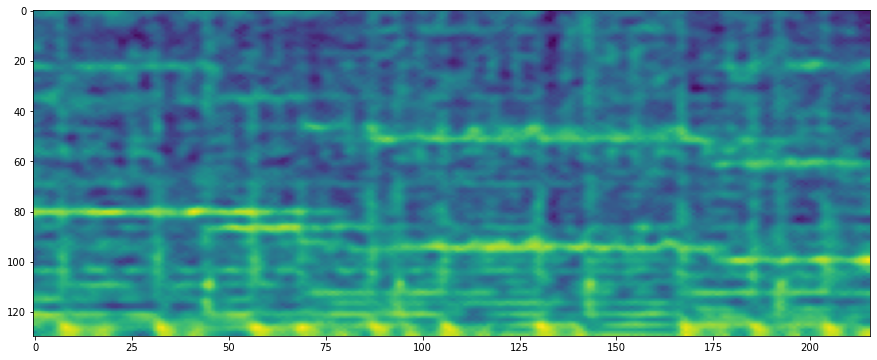

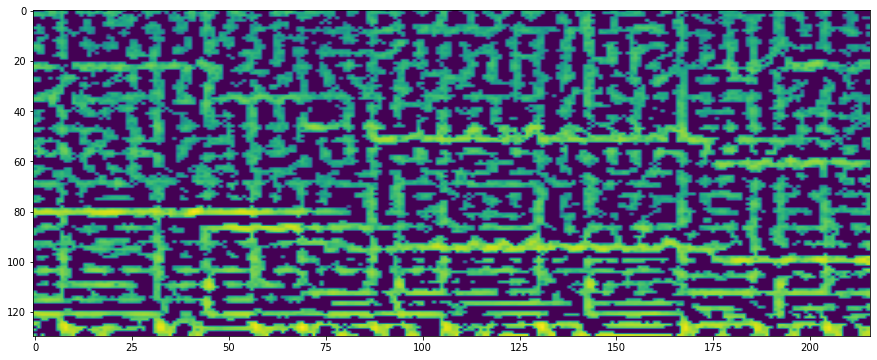

In [251]:
img = cv2.bilateralFilter(fspec, 5, 200, 200)

plt.figure(figsize=(15, 6))
plt.imshow(img, aspect='auto')

threshold_img = normalize(img)

threshold_mask = cv2.adaptiveThreshold(threshold_img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 9, 0)
 
plt.figure(figsize=(15, 6))
plt.imshow(threshold_mask * fspec, aspect='auto')

Time-series (column-wise) thresholding

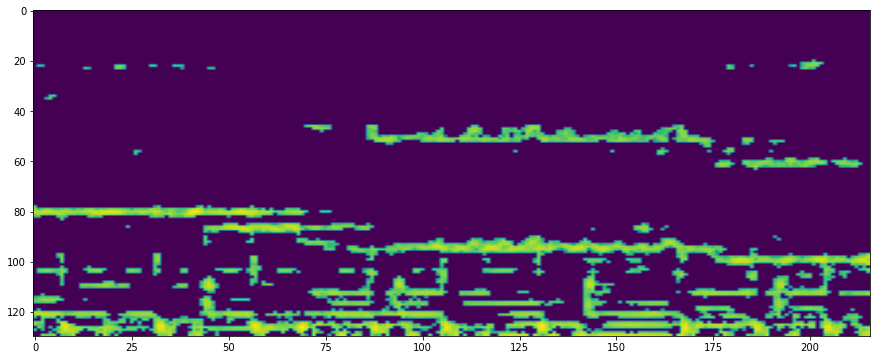

In [252]:
colwise_mask = img

# center signal(s)
colwise_mask = center(np.swapaxes(colwise_mask, 0, 1))
colwise_mask[colwise_mask < 0] = 0.0

# filter each time step
for i in range(len(colwise_mask)):
    bar = colwise_mask[i]
    bar[bar < np.max(bar) * 0.4] = 0.0
    colwise_mask[i,:] = bar

colwise_mask = np.swapaxes(colwise_mask, 0, 1)
threshold = threshold_local(colwise_mask, 7)
colwise_mask = colwise_mask > threshold
colwise_mask = colwise_mask.astype(np.uint8)

plt.figure(figsize=(15, 6))
plt.imshow(colwise_mask * fspec, aspect='auto')

Frequency based (row-wise) filtering/processing

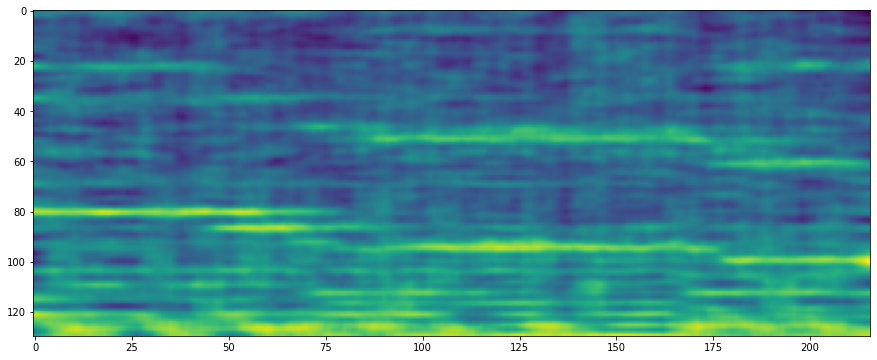

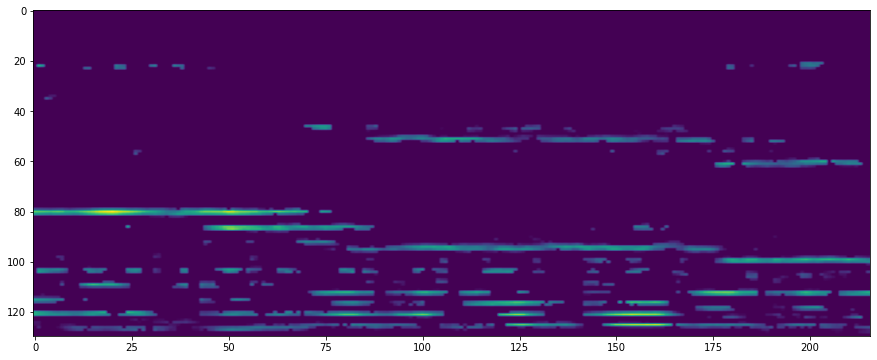

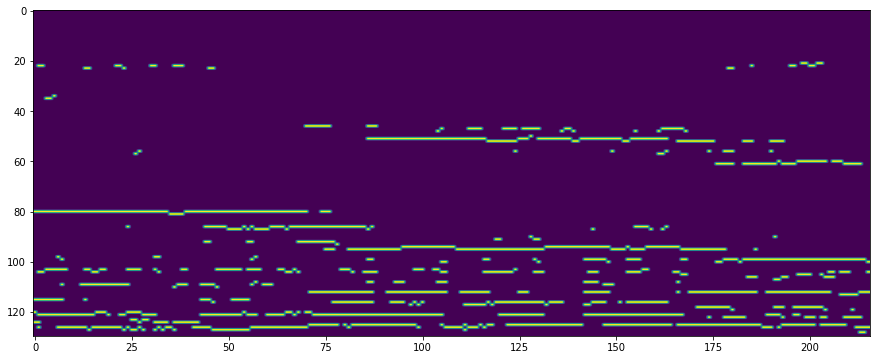

In [253]:
def push_segments(row, peaks):
    leveled_row = row.copy()
    prev = peaks[0]
    for peak in peaks[1:]:
        segment = leveled_row[prev:peak]
        leveled_row[prev:peak] = np.ones((peak - prev,)) * np.max(segment)
        prev = peak
    return leveled_row

def generate_heat_map(img):
    heat_map = np.zeros(img.shape)
    for i in range(1, img.shape[0] - 1):
        heat_map[i,:] = img[i,:] - img[i-1,:] + img[i,:] - img[i+1,:]
    return heat_map

filt_img = ndimage.gaussian_filter1d(fspec, 1.0, axis=0)
filt_img = savgol_filter(filt_img, 9, 1, axis=1)

plt.figure(figsize=(15, 6))
plt.imshow(filt_img, aspect='auto')

heat_map = generate_heat_map(filt_img)
init_img = heat_map * colwise_mask * threshold_mask
init_img[init_img < 0] = 0
init_img = normalize(init_img)

plt.figure(figsize=(15, 6))
plt.imshow(init_img, aspect='auto')

rowwise_mask = init_img.copy()
rowwise_mask = np.swapaxes(rowwise_mask, 0, 1)

for i, row in enumerate(rowwise_mask):
    peaks, _ = signal.find_peaks(row) 
    peaks = set(peaks)
    for j in range(len(row)):
        if j not in peaks: row[j] = 0.0
    rowwise_mask[i,:] = row

rowwise_mask = np.swapaxes(rowwise_mask, 0, 1)
rowwise_mask[rowwise_mask != 0.0] = 1.0
rowwise_mask = rowwise_mask.astype(np.uint8)

plt.figure(figsize=(15, 6))
plt.imshow(rowwise_mask, aspect='auto')

Remove Connections

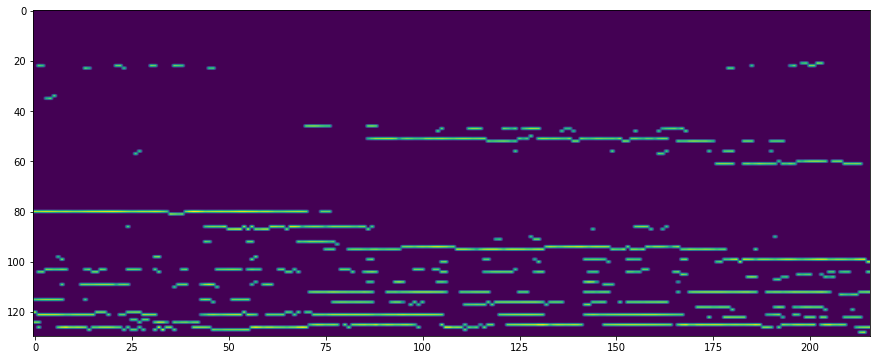

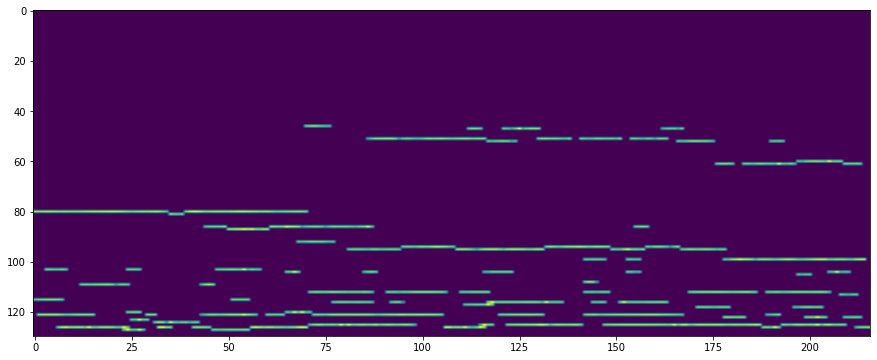

In [254]:
def remove_connections(img):
    filtered_img = img.copy()
    for x in range(1, img.shape[0] - 1):
        for y in range(1, img.shape[1] - 1):
            pix = img[x, y]
            if pix != 0:
                p1, _, p3, _, _, p6, _, p8 = check_connectivity(img, x, y)
                if (p1 and p8) or (p3 and p6):
                    filtered_img[x, y] = 0
    return filtered_img

def fix_connections(img):
    filtered_img = img.copy()
    for x in range(1, img.shape[0] - 1):
        for y in range(1, img.shape[1] - 1):
            pix = img[x, y]
            if pix == 0:
                p1, p2, p3, p4, p5, p6, p7, p8 = check_connectivity(img, x, y)
                if (p1 and p8) or (p3 and p6) or (p2 and p7) or (p4 and p5):
                    filtered_img[x, y] = 255
    return filtered_img

def check_connectivity(img, x, y):
    p1 = int(img[x-1, y-1] != 0)
    p3 = int(img[x-1, y+1] != 0)
    p6 = int(img[x+1, y-1] != 0)
    p8 = int(img[x+1, y+1] != 0)
    p2 = int(img[x-1, y] != 0)
    p7 = int(img[x+1, y] != 0)
    p4 = int(img[x, y-1] != 0)
    p5 = int(img[x, y+1] != 0)
    return p1, p2, p3, p4, p5, p6, p7, p8
    
img_restored = rowwise_mask * fspec

plt.figure(figsize=(15, 6))
plt.imshow(img_restored, aspect='auto')

img_restored = fix_connections(img_restored)
img_restored = remove_small_components(img_restored, filter_size=3)
img_restored = remove_connections(img_restored)

plt.figure(figsize=(15, 6))
plt.imshow(img_restored, aspect='auto')

Countour detection and feature smoothing

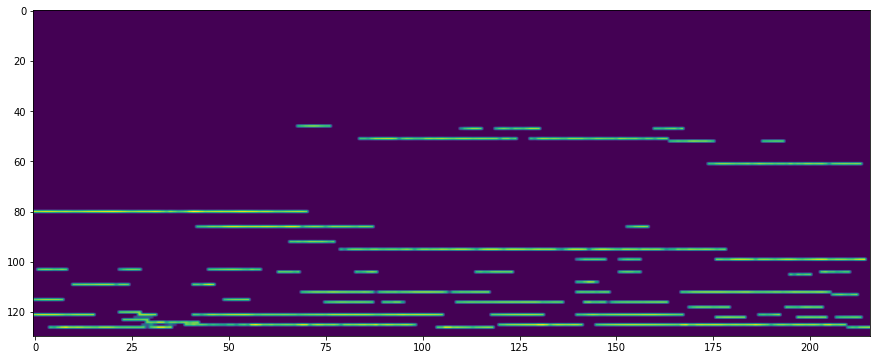

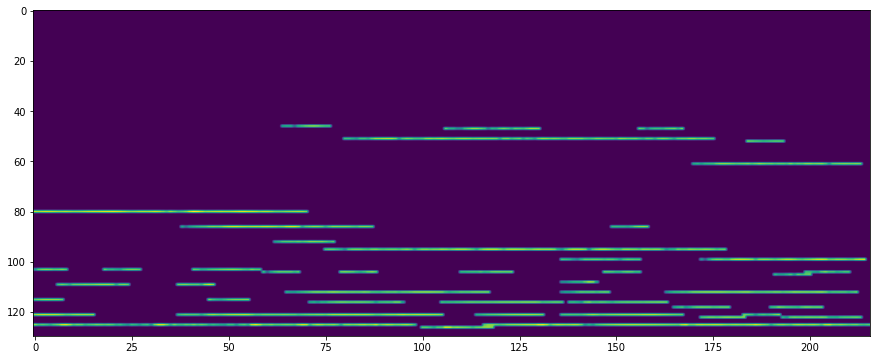

In [255]:
def press_features(contours, extend_contour=0):
    ironed_features = []
    for c in contours:
        top, bot = shape_endpoints(c, row=0)
        right, left = shape_endpoints(c, row=1)
        if left < right and bot < top:
            left -= extend_contour
            if left < 0: left = 0
            contour = [[left, top], [right + 1, top], 
                        [right + 1, bot], [left, bot]]
            ironed_features.append(contour)
    return np.array(ironed_features)

def shape_endpoints(contour, row=1):
    k, v = 1, 0
    dimension = {}
    for pt in contour:
        if pt[k].item() not in dimension:   
            dimension[pt[k].item()] = set([pt[v].item()])
        else:
            dimension[pt[k].item()].add(pt[v].item())
    if row:
        right = np.max([max(d) for _, d in dimension.items()])
        left = np.min([min(d) for _, d in dimension.items()])
        return right, left
    else:
        bot = max(dimension, key=lambda k: len(dimension[k]))
        return bot + 1, bot

def draw_contours(canvas, contours):
    for contour in contours:
        ul, ur, lr, ll = contour[0], contour[1], contour[2], contour[3]
        bot, top, left, right = lr[1], ul[1], ll[0], ur[0]
        canvas[bot:top, left:right] = np.ones((top - bot, right - left))
    return canvas

def unwrap_contours(contours):
    unwrapped = []
    for contour in contours:
        unwrapped.append([c[0] for c in contour])
    return np.array(unwrapped)
    
contour_img = img_restored.copy()

shape = contour_img.shape

contours, _ = cv2.findContours(contour_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = unwrap_contours(contours)

pressed_contours = press_features(contours, extend_contour=2)
contour_mask = draw_contours(np.zeros(shape), pressed_contours).astype(np.uint8)
contour_mask = fix_connections(contour_mask)

plt.figure(figsize=(15, 6))
plt.imshow(contour_mask * fspec, aspect='auto')

note_contours, _ = cv2.findContours(contour_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
note_contours = unwrap_contours(note_contours)
note_contours = press_features(note_contours, extend_contour=4)
contour_mask = draw_contours(np.zeros(shape), note_contours).astype(np.uint8)
notes_img = contour_mask * fspec

# original_contours = cv2.drawContours(np.zeros(shape), note_contours, 
#                                      -1, 1, thickness=cv2.FILLED)
# plt.figure(figsize=(15, 6))
# plt.imshow(original_contours, aspect='auto')

plt.figure(figsize=(15, 6))
plt.imshow(notes_img, aspect='auto')

Onset detection

In [256]:
def downsample_spectrogram(spectrogram, ds=2):
    shape = spectrogram.shape
    ds_spec = np.zeros((int(shape[0]//ds), shape[1]))
    for i in range(int(shape[0]//ds)):
        index = i * ds
        ds_spec[i] = np.average(spectrogram[index:index+ds], axis=0)
    return ds_spec

def upsample_spectrogram(spectrogram, shape, ds):
    us_spec = np.zeros(shape)
    for i in range(spectrogram.shape[0]):
        us_spec[i*ds:i*ds+ds] = np.tile(spectrogram[i], (ds, 1))
    return us_spec

def average_locally(onsets, n_comp=3):
    output = onsets.copy()
    for i in range(0, len(output), n_comp):
        comparator = output[i:i+n_comp]
        f = np.max(comparator, axis=0)
        f = np.tile(f, (comparator.shape[0], 1))
        output[i:i+n_comp] = f
    return output

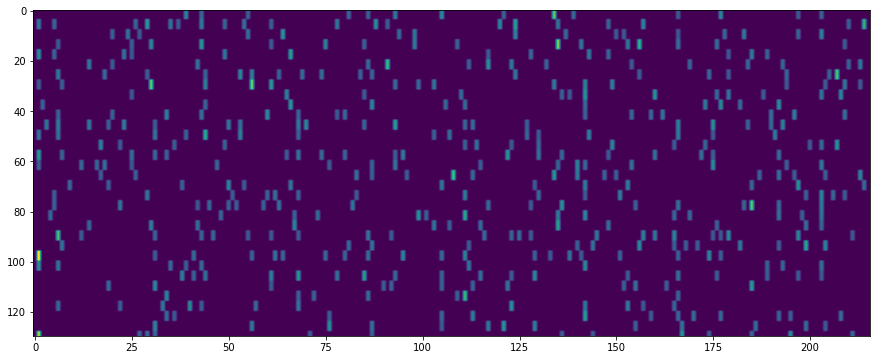

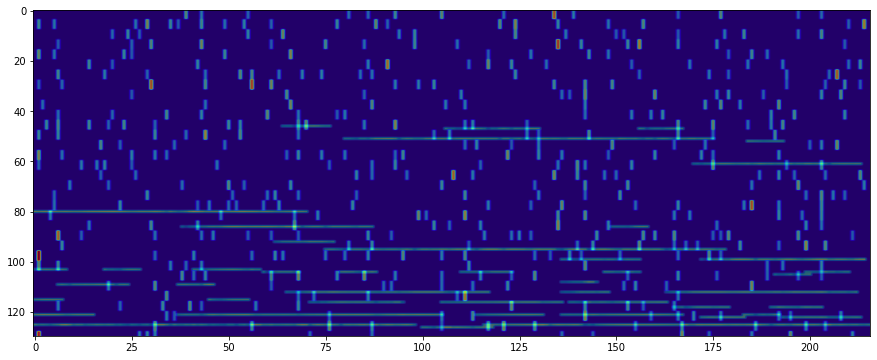

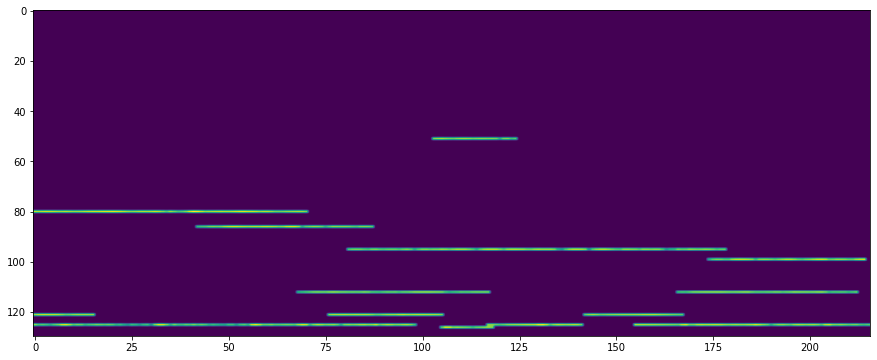

In [257]:
def extract_contour(spectrogram, spectral, contour):
    ul, ur, lr, ll = contour[0], contour[1], contour[2], contour[3]
    bot, top, left, right = lr[1], ul[1], ll[0], ur[0]
    note = np.max(spectrogram[bot:top,left:right], axis=0)
    flux = np.max(spectral[bot:top,left:right], axis=0)
    return note, flux, (bot, top, left, right)

def remove_start_diff(spectral, start_pts):
    for pt in start_pts:
        if pt[1] != 0:
            spectral[pt] = 0

def remove_repeating_onsets(onsets, dist=2):
    if len(onsets) == 0: return onsets
    prev = onsets[0]
    filtered_onsets = [prev]
    for o in onsets[1:]:
        if o - prev > dist:
            filtered_onsets.append(o)
            prev = o
    return filtered_onsets

def get_peaks(spectral):
    output = np.zeros(spectral.shape)
    for i, row in enumerate(spectral):
        peaks, _ = signal.find_peaks(row)
        peaks = np.concatenate(([0], peaks))
        peaks = set(peaks)
        for j in range(spectral.shape[1]):
            output[i,j] = spectral[i,j] if j in peaks else 0
    return output

def threshold_notes(notes, thresh=0.7):
    stats = np.array([n[0] for n in notes]).astype(float)
    stats -= np.min(stats)
    stats /= np.max(stats)
    return [note for i, note in enumerate(notes) if stats[i] > thresh]

def find_nonzero_means(matrix):
    nonzeros = []
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            if matrix[x, y] != 0:
                nonzeros.append(matrix[x, y])
    return np.average(nonzeros)

spectral = diff_matrix(fspec)
spectral = average_locally(spectral, n_comp=4)
spectral[:,0] = np.zeros((1, spectral.shape[0]))
spectral[spectral < np.max(spectral) * 0.3] = 0.0
spectral = get_peaks(spectral)

plt.figure(figsize=(15, 6))
plt.imshow(spectral, aspect='auto')

onset_fixed_notes = []

for contour in note_contours:
    note, flux, pos = extract_contour(fspec, spectral, contour)
    bot, top, left, right = pos
    onset, _ = signal.find_peaks(flux)
    if left == 0:
        onset = np.concatenate(([0], onset))
    if len(onset) == 0:
        continue
    left += onset[0]
    contour = [[left, bot+1], [right, bot+1], [right, bot], [left, bot]]
    onset_fixed_notes.append(contour)

extracted_notes = []

for note in onset_fixed_notes:
    note, _, pos = extract_contour(fspec, spectral, note)
    extracted_notes.append((np.max(note), pos))

notes = threshold_notes(extracted_notes, thresh=0.4)
# notes = extracted_notes

extracted_img = np.zeros(fspec.shape)

for note in notes:
    bot, top, left, right = note[1]
    extracted_img[bot:top, left:right] = np.ones((top - bot, right - left))

extracted_img *= fspec
extracted_img = remove_small_components(extracted_img, filter_size=5)

plt.figure(figsize=(15, 6))
plt.imshow(notes_img, aspect='auto')
plt.imshow(spectral, cmap='jet', alpha=0.5, aspect='auto')

plt.figure(figsize=(15, 6))
# plt.imshow(fspec, aspect='auto')
plt.imshow(extracted_img, aspect='auto')
# plt.imshow(extracted_img * fspec, cmap='jet', alpha=0.3, aspect='auto')

Extract notes

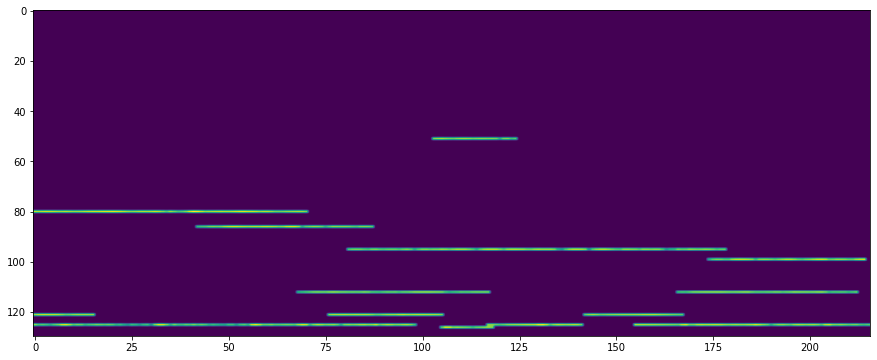

In [258]:
# !pip install midiutil
# !pip install audiolazy
# from midiutil.MidiFile import MIDIFile
# from audiolazy.lazy_midi import freq2midi

def pure_tone_gen_fs(freq, fs, duration, amplitude=1, phase=0):
    """
    Generate a NumPy array which contains samples (spaced apart by 1 / fs) of a sine wave representing the note
    "note" for duration seconds with amplitude and phase as given. If the note is outside the middle C octave,
    then octave_offset specifies how many octaves above or below it should be.

    Parameters:
    freq          - Pitch of note to generate.
    fs            - The sampling frequency, that is, the number of samples to use per second of data generated.
    duration      - The length, in seconds, of the pure tone to generate.
    amplitude     - The amplitude of the note.
    phase         - The phase of the note.
    octave_offset - How many octaves below or above the octave {A, A#, ..., Middle C, ..., G, G#} the desired 
                    note is. For example, setting this parameter to zero and note to "C" would generate Middle C.
    """
    samples = np.round(fs*duration).astype(int)
    timespace = np.pi * 2 * freq * np.linspace(0, duration, samples) + phase
    waveform = amplitude * np.sin(timespace)
    return waveform

pitches = frequencies
time_per_frame = hop_length / sr

final_img = extracted_img.copy()
# final_img = img_restored.copy()
# final_img = notes_img.copy()

plt.figure(figsize=(15, 6))
plt.imshow(final_img, aspect='auto')

final_img = np.flipud(final_img)
# midi_frequencies
# time_per_frame

In [259]:
max_volume = np.max(audio_clip) * 0.8
max_in_spec = np.max(final_img)
duration = int(duration)

tracks = np.zeros((duration * sr,))

for i, row in enumerate(final_img):
    pitch = pitches[i]
    new_note = True
    length, volumes = 0, []
    if np.count_nonzero(row) == 0:
        continue
    row = np.concatenate((row, [0]))
    for j in range(len(row)):
        if row[j] != 0.0:
            if new_note: 
                time, new_note = time_per_frame * j * sr, False
            volumes.append(row[j])
            length += 1
        else:
            if length > 0:
                length *= time_per_frame
                time = int(np.round(time))
                volume = np.min(volumes) / max_in_spec * max_volume / 2
                sound = pure_tone_gen_fs(pitch, sr, length, amplitude=volume)
                if time + len(sound) > len(tracks):
                    sound = sound[:-(time + len(sound) - len(tracks))]
                tracks[time:time+len(sound)] += sound
            length, volumes, new_note = 0, [], True

layover = tracks + audio_clip

ipd.display(ipd.Audio(tracks, rate=sr))
ipd.display(ipd.Audio(layover, rate=sr))
# ipd.display(ipd.Audio(audio_clip, rate=sr))

<Figure size 1224x432 with 0 Axes>

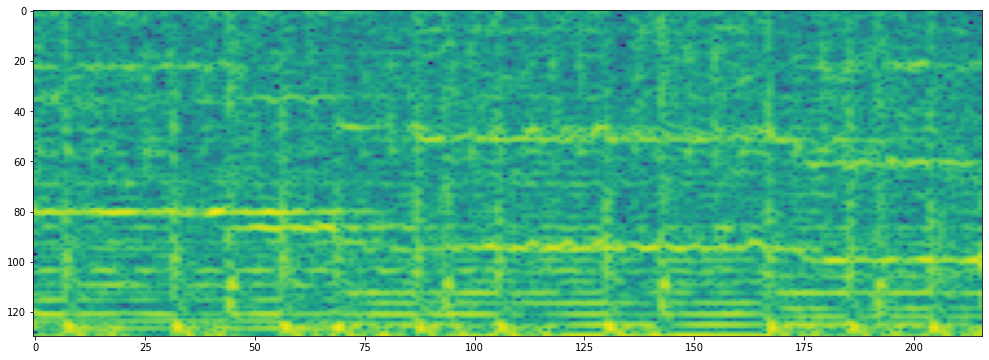

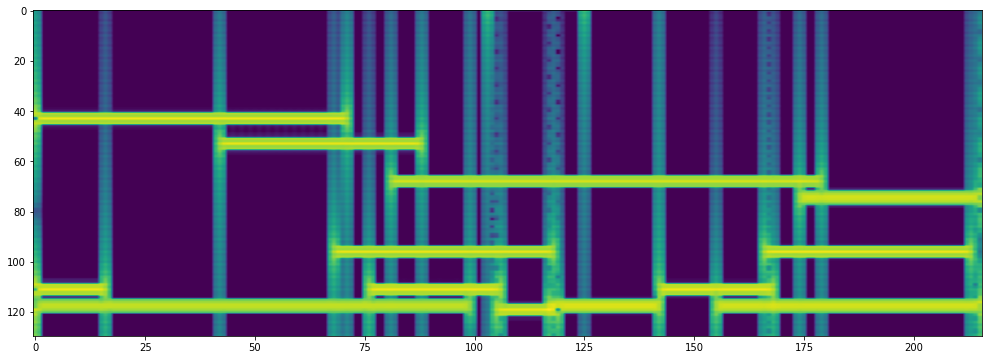

In [260]:
plt.figure(figsize=(17, 6))
out = librosa.feature.melspectrogram(tracks, n_fft=n_fft, hop_length=hop_length, 
                                     sr=sr, n_mels=n_mels, fmax=2000)
out = librosa.power_to_db(out, ref=np.max)
out = np.flipud(out[start:end])

plt.figure(figsize=(17, 6))
plt.imshow(fspec, aspect='auto')

plt.figure(figsize=(17, 6))
plt.imshow(out, aspect='auto')#cmap='jet', alpha=0.3, 

In [261]:
def write_wav(original, fname='./test.wav', fs=44100):
    out = original.copy()
    out /= np.max(np.abs(out))
    out *= 1000
    out = out.astype(np.int16)
    wavfile.write(fname, fs, out)

write_wav(layover, fs=sr)